In [ ]:
!pip install pulp folium

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
import folium
from folium.plugins import MarkerCluster

In [ ]:
df1 = pd.read_csv('TX_suppliers.csv')
df2 = pd.read_csv('TX_hubs.csv')
df3 = pd.read_csv('TX_plants.csv')
df4 = pd.read_csv('TX_roads.csv') 
df5 = pd.read_csv('TX_railroads.csv') 
df5

,index,hub,plant,distance,cost,loading,capacity
0,1,17201,541,922.023251,17.095711,3066792,338000
1,2,17201,542,1160.842967,20.923752,3066792,338000
2,3,17201,543,186.924258,5.312809,3066792,338000
3,4,17201,544,1074.699073,19.542951,3066792,338000
4,5,17201,545,1160.842967,20.923752,3066792,338000
...,...,...,...,...,...,...,...
5506,5507,18303,10061,1132.963314,20.476869,3066792,338000
5507,5508,18303,10062,1330.810658,23.648164,3066792,338000
5508,5509,18303,10063,1223.144021,21.922376,3066792,338000
5509,5510,18303,10065,1717.592064,29.847883,3066792,338000


In [ ]:
suppliers1 = df1.dropna(subset=['county'])
suppliers = suppliers1['county']

In [48]:

hubs = df2['hub']
hub_invest = df2['invest']
hub_capacity = df2['capacity']

In [49]:

plants = df3['plant']
plant_invest = df3['invest']
plant_capacity = df3['capacity']

In [50]:

truck_transportation_cost = df4['cost']
train_transportation_cost = df5['cost']
train_load_cost = df5['loading']   # cost to load/unload at rail stations
train_capacity = df5['capacity']

In [51]:
# Build dictionaries that map each route to its cost

cost_in_truck = {(row['county'].astype(int), row['hub'].astype(int)): row['cost'] 
                 for _, row in df4.iterrows()}
cost_in_train = {(row['hub'].astype(int), row['plant'].astype(int)): row['cost'] 
                 for _, row in df5.iterrows()}


print("Sample truck routes (supplier -> hub): cost")
for key, value in list(cost_in_truck.items())[:5]:
    print(f"  {key}: ${value:.2f}")

print("\nSample train routes (hub -> plant): cost")
for key, value in list(cost_in_train.items())[:5]:
    print(f"  {key}: ${value:.2f}")

Sample truck routes (supplier -> hub): cost
  (np.int64(48001), np.int64(17201)): $40.58
  (np.int64(48001), np.int64(17218)): $47.66
  (np.int64(48001), np.int64(17359)): $64.27
  (np.int64(48001), np.int64(17372)): $72.00
  (np.int64(48001), np.int64(17395)): $37.39

Sample train routes (hub -> plant): cost
  (np.int64(17201), np.int64(541)): $17.10
  (np.int64(17201), np.int64(542)): $20.92
  (np.int64(17201), np.int64(543)): $5.31
  (np.int64(17201), np.int64(544)): $19.54
  (np.int64(17201), np.int64(545)): $20.92


In [42]:
# Build dictionaries for supplier supply and hub/plant capacities
supplier_dict = {row['county']: row['supply'] for _, row in suppliers1.iterrows()}
hubs_dict = {row['hub']: row['capacity'] for _, row in df2.iterrows()}
plants_dict = {row['plant']: row['capacity'] for _, row in df3.iterrows()}


print("Supplier capacities (first 5):")
for key, value in list(supplier_dict.items())[:5]:
    print(f"  County {int(key)}: {value:,.0f} Mg")

print("\nHub capacities (first 5):")
for key, value in list(hubs_dict.items())[:5]:
    print(f"  Hub {int(key)}: {value:,.0f} Mg")

print("\nPlant capacities (first 5):")
for key, value in list(plants_dict.items())[:5]:
    print(f"  Plant {int(key)}: {value:,.0f} Mg")

Supplier capacities (first 5):
  County 48001: 13,132 Mg
  County 48003: 1,177 Mg
  County 48005: 3,855 Mg
  County 48007: 308 Mg
  County 48009: 19,802 Mg

Hub capacities (first 5):
  Hub 17201: 300,000 Mg
  Hub 17218: 300,000 Mg
  Hub 17359: 300,000 Mg
  Hub 17372: 300,000 Mg
  Hub 17395: 300,000 Mg

Plant capacities (first 5):
  Plant 541: 152,063,705 Mg
  Plant 542: 152,063,705 Mg
  Plant 543: 152,063,705 Mg
  Plant 544: 152,063,705 Mg
  Plant 545: 152,063,705 Mg


In [52]:
# Create lists of suppliers, hubs, and plants
suppliers_list = list(supplier_dict.keys())
hubs_list = list(hubs_dict.keys())
plants_list = list(plants_dict.keys())

third_party_cost_options = [500, 1000, 2000]

print(f"Dataset size:")
print(f"  {len(suppliers_list)} suppliers (biomass sources)")
print(f"  {len(hubs_list)} potential hubs")
print(f"  {len(plants_list)} potential plants")
print(f"\nTotal biomass available from local suppliers: {sum(supplier_dict.values()):,.0f} Mg")
print(f"Available routes: {len(cost_in_truck)} truck, {len(cost_in_train)} train")

Dataset size:
  254 suppliers (biomass sources)
  33 potential hubs
  167 potential plants

Total biomass available from local suppliers: 3,053,378 Mg
Available routes: 8382 truck, 5511 train


In [53]:
# Define the optimization model
model = LpProblem("Bioethanol_Supply_Chain", LpMinimize)

In [54]:

yj = {}
zk = {}

In [55]:
# Create all the decision variables
# Binary variables for facility location decisions
for j in hubs_list:
    yj[j] = LpVariable(f"y_{int(j)}", cat='Binary')
for k in plants_list:
    zk[k] = LpVariable(f"z_{int(k)}", cat='Binary')

# Flow variables - how much biomass moves along each route
# Only create variables for routes that actually exist in our data
Sij = {(i,j): LpVariable(f"Sij_{int(i)}_{int(j)}", lowBound=0, cat='Continuous') 
       for i in suppliers_list for j in hubs_list if (i,j) in cost_in_truck}
Sjk = {(j,k): LpVariable(f"Sjk_{int(j)}_{int(k)}", lowBound=0, cat='Continuous') 
       for j in hubs_list for k in plants_list if (j,k) in cost_in_train}

# Third-party supply - biomass we buy from external sources
St = LpVariable("St", lowBound=0, cat='Continuous')

print(f"Variables created:")
print(f"  {len(yj)} hub location choices")
print(f"  {len(zk)} plant location choices")
print(f"  {len(Sij)} truck shipping routes (supplier to hub)")
print(f"  {len(Sjk)} train shipping routes (hub to plant)")
print(f"  1 third-party supply variable")

Variables created:
  33 hub location choices
  167 plant location choices
  8382 truck shipping routes (supplier to hub)
  5511 train shipping routes (hub to plant)
  1 third-party supply variable


In [56]:
# -------------------------
# Model Parameters
# -------------------------
# These numbers come from the problem specification. The key values are:
#
# Investment costs (one-time):
#   - Hub: $3.47M each
#   - Plant: $130.96M each
#
# Capacities (annual throughput):
#   - Hub: 300,000 Mg
#   - Plant: 655,447 Mg (= 152,063,705 / 232)
#   - Train: 338,000 Mg per route
#
# Operating costs:
#   - Truck transport: varies by route (from data)
#   - Train transport: varies by route (from data) + loading cost
#   - Loading/unloading: $9.07/Mg (= 3,066,792 / 338,000)
#
# Demand: 6,363,408 Mg (= 1,476,310,602 / 232)
# Third-party price: varies (this is what we'll analyze)

fj = 3476219           # hub investment ($)
gk = 130956797         # plant investment ($)
qj = 300000            # hub capacity (Mg)
pk = 655447            # plant capacity (Mg)
tj = 338000            # train capacity (Mg)
ljk = 3066792/338000   # loading/unloading cost ($/Mg)
D = 6363408            # total demand (Mg)

print("Model Parameters")
print("-" * 50)
print(f"Hub Investment:       ${fj:>15,}")
print(f"Plant Investment:     ${gk:>15,}")
print(f"Hub Capacity:         {qj:>15,} Mg")
print(f"Plant Capacity:       {pk:>15,} Mg")
print(f"Train Capacity:       {tj:>15,} Mg")
print(f"Loading Cost:         ${ljk:>14.2f}/Mg")
print(f"Total Demand:         {D:>15,} Mg")
print("-" * 50)
print(f"Local Supply:         {sum(supplier_dict.values()):>15,.0f} Mg")
print(f"Gap (need 3rd party): {D - sum(supplier_dict.values()):>15,.0f} Mg")

Model Parameters
--------------------------------------------------
Hub Investment:       $      3,476,219
Plant Investment:     $    130,956,797
Hub Capacity:                 300,000 Mg
Plant Capacity:               655,447 Mg
Train Capacity:               338,000 Mg
Loading Cost:         $          9.07/Mg
Total Demand:               6,363,408 Mg
--------------------------------------------------
Local Supply:               3,053,378 Mg
Gap (need 3rd party):       3,310,030 Mg


In [57]:
# -------------------------
# Objective Function
# -------------------------
# We want to minimize total annual cost, which has five parts:
#
# 1. Hub investment:     sum of fj for each hub we open
# 2. Plant investment:   sum of gk for each plant we open
# 3. Truck transport:    cost to ship biomass from suppliers to hubs
# 4. Train transport:    cost to ship from hubs to plants (includes loading)
# 5. Third-party supply: cost to buy biomass from external market
#
# The third-party price (G) is what we'll vary in our sensitivity analysis

print("Objective: Minimize Total Cost")
print()
print("  Total Cost = Hub Investment")
print("             + Plant Investment")
print("             + Truck Transport")
print("             + Train Transport (including loading)")
print("             + Third-Party Purchases")
print()
print("We'll solve this for different third-party prices to see how it affects the design.")

Objective: Minimize Total Cost

  Total Cost = Hub Investment
             + Plant Investment
             + Truck Transport
             + Train Transport (including loading)
             + Third-Party Purchases

We'll solve this for different third-party prices to see how it affects the design.


In [ ]:
# -------------------------
# Sensitivity Analysis
# -------------------------
# The big question: how does the external market price affect our decision?
# If third-party biomass is cheap, maybe we buy more and build fewer facilities.
# If it's expensive, we might want to maximize our own production.
#
# Let's run the model at different price points and see what happens.

G_values = [50, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000]

print("Running Sensitivity Analysis on Third-Party Price")
print("=" * 80)
print(f"\nDemand target: {D:,} Mg")
print(f"Local supply available: {sum(supplier_dict.values()):,.0f} Mg")
print(f"Minimum third-party needed: {D - sum(supplier_dict.values()):,.0f} Mg")
print("\n" + "-" * 80)

sensitivity_results = []
for G in G_values:
    result = solve_supply_chain_model(
        G=G, D=D, fj=fj, gk=gk, qj=qj, pk=pk, tj=tj, ljk=ljk,
        suppliers_list=suppliers_list, hubs_list=hubs_list, plants_list=plants_list,
        supplier_dict=supplier_dict, cost_in_truck=cost_in_truck, cost_in_train=cost_in_train
    )
    
    if result['status'] == 'optimal':
        result['G'] = G
        sensitivity_results.append(result)
        
        own_pct = result['company_production'] / D * 100
        third_pct = result['third_party_supply'] / D * 100
        
        print(f"G=${G:>4}/Mg: Cost=${result['total_cost']/1e9:>6.2f}B | "
              f"Own:{own_pct:>5.1f}% | 3rd:{third_pct:>5.1f}% | "
              f"Hubs:{result['num_hubs']:>2} Plants:{result['num_plants']:>2}")
    else:
        print(f"G=${G}/Mg: No feasible solution found")

print("-" * 80)
print("\nDone! See below for detailed results.")

SENSITIVITY ANALYSIS: Impact of Third-Party Price (G) on Supply Chain

Total Demand (D): 6,363,408 Mg
Available Local Supply: 3,053,377.71 Mg
Supply Gap (must use third-party): 3,310,030.29 Mg

--------------------------------------------------------------------------------
G=$  50/Mg: Cost=$  0.32B | Own:  0.0% | 3rd:100.0% | Hubs: 0 Plants: 0
G=$ 100/Mg: Cost=$  0.64B | Own:  0.0% | 3rd:100.0% | Hubs: 0 Plants: 0
G=$ 150/Mg: Cost=$  0.95B | Own:  0.0% | 3rd:100.0% | Hubs: 0 Plants: 0
G=$ 200/Mg: Cost=$  1.27B | Own:  0.0% | 3rd:100.0% | Hubs: 0 Plants: 0
G=$ 250/Mg: Cost=$  1.58B | Own: 30.9% | 3rd: 69.1% | Hubs: 7 Plants: 3
G=$ 300/Mg: Cost=$  1.78B | Own: 41.2% | 3rd: 58.8% | Hubs:10 Plants: 4
G=$ 400/Mg: Cost=$  2.14B | Own: 48.0% | 3rd: 52.0% | Hubs:11 Plants: 5
G=$ 500/Mg: Cost=$  2.47B | Own: 48.0% | 3rd: 52.0% | Hubs:11 Plants: 5
G=$ 750/Mg: Cost=$  3.30B | Own: 48.0% | 3rd: 52.0% | Hubs:11 Plants: 5
G=$1000/Mg: Cost=$  4.13B | Own: 48.0% | 3rd: 52.0% | Hubs:11 Plants: 5
G=$15

In [ ]:
# -------------------------
# Detailed Results for a Specific Price Point
# -------------------------
# Let's dig into what the optimal network looks like at G = $500/Mg

G_display = 500  # change this to explore other scenarios

result = next((r for r in sensitivity_results if r['G'] == G_display), None)

if result:
    print(f"Detailed Results at G = ${G_display}/Mg")
    print("=" * 60)
    
    print(f"\nTotal Annual Cost: ${result['total_cost']:,.0f}")
    print(f"                   (${result['total_cost']/1e9:.3f} Billion)")
    
    print(f"\nFacilities to Build:")
    print(f"  Hubs:   {result['num_hubs']} locations - {[int(h) for h in result['opened_hubs']]}")
    print(f"  Plants: {result['num_plants']} locations - {[int(p) for p in result['opened_plants']]}")
    
    print(f"\nSupply Mix:")
    print(f"  Own production:    {result['company_production']:>12,.0f} Mg ({result['company_production']/D*100:.1f}%)")
    print(f"  Third-party:       {result['third_party_supply']:>12,.0f} Mg ({result['third_party_supply']/D*100:.1f}%)")
    print(f"  Total:             {result['company_production'] + result['third_party_supply']:>12,.0f} Mg")
    
    print(f"\nCost Breakdown:")
    print(f"  Hub Investment:      ${result['hub_investment']:>14,.0f}  ({result['hub_investment']/result['total_cost']*100:>5.1f}%)")
    print(f"  Plant Investment:    ${result['plant_investment']:>14,.0f}  ({result['plant_investment']/result['total_cost']*100:>5.1f}%)")
    print(f"  Truck Transport:     ${result['truck_cost']:>14,.0f}  ({result['truck_cost']/result['total_cost']*100:>5.1f}%)")
    print(f"  Train Transport:     ${result['train_cost']:>14,.0f}  ({result['train_cost']/result['total_cost']*100:>5.1f}%)")
    print(f"  Third-Party:         ${result['third_party_cost']:>14,.0f}  ({result['third_party_cost']/result['total_cost']*100:>5.1f}%)")
    print(f"  " + "-" * 50)
    print(f"  TOTAL:               ${result['total_cost']:>14,.0f}")
else:
    print(f"No results found for G = ${G_display}/Mg")


DETAILED RESULTS FOR G = $500/Mg

Total Cost: $2,474,789,196.85
Total Cost: $2.475 Billion

OPENED FACILITIES:
Hubs Opened: 11 - [17372, 17466, 17592, 17620, 17679, 17792, 17822, 17829, 17934, 17945, 18127]
Plants Opened: 5 - [541, 543, 9047, 9203, 10066]

SUPPLY SOURCES:
Company Production: 3,053,377.72 Mg (48.0%)
Third-Party Supply: 3,310,030.30 Mg (52.0%)
Total Demand Met: 6,363,408.02 Mg

COST BREAKDOWN:
Hub Investment:      $  38,238,409.00 (  1.5%)
Plant Investment:    $ 654,783,985.00 ( 26.5%)
Truck Transportation:$  79,804,105.07 (  3.2%)
Train Transportation:$  46,947,547.79 (  1.9%)
Third-Party Cost:    $1,655,015,150.00 ( 66.9%)
------------------------------------------------------------
TOTAL:               $2,474,789,196.85


In [ ]:
# -------------------------
# The Optimization Solver
# -------------------------
# This function builds and solves the mixed-integer linear program.
# Given a third-party price G, it finds the lowest-cost network design.

def solve_supply_chain_model(G, D, fj, gk, qj, pk, tj, ljk,
                              suppliers_list, hubs_list, plants_list, 
                              supplier_dict, cost_in_truck, cost_in_train):
    """
    Find the minimum-cost supply chain configuration.
    
    Args:
        G: third-party biomass price ($/Mg)
        D: total demand to satisfy (Mg)
        fj, gk: investment costs for hubs and plants
        qj, pk, tj: capacity limits
        ljk: loading/unloading cost
        *_list: sets of suppliers, hubs, plants
        *_dict: capacity and cost lookups
    
    Returns:
        Dictionary with solution details, or {'status': 'infeasible'}
    """
    model = LpProblem("Bioethanol_Supply_Chain", LpMinimize)
    
    # Facility location decisions (binary)
    yj = {j: LpVariable(f"y_{int(j)}", cat='Binary') for j in hubs_list}
    zk = {k: LpVariable(f"z_{int(k)}", cat='Binary') for k in plants_list}
    
    # Flow decisions (continuous, non-negative)
    Sij = {(i,j): LpVariable(f"Sij_{int(i)}_{int(j)}", lowBound=0) 
           for i in suppliers_list for j in hubs_list if (i,j) in cost_in_truck}
    Sjk = {(j,k): LpVariable(f"Sjk_{int(j)}_{int(k)}", lowBound=0) 
           for j in hubs_list for k in plants_list if (j,k) in cost_in_train}
    St = LpVariable("St", lowBound=0)
    
    # Objective: minimize total cost
    model += (
        lpSum(fj * yj[j] for j in hubs_list) +
        lpSum(gk * zk[k] for k in plants_list) +
        lpSum(cost_in_truck[i,j] * Sij[i,j] for (i,j) in Sij.keys()) +
        lpSum((cost_in_train[j,k] + ljk) * Sjk[j,k] for (j,k) in Sjk.keys()) +
        G * St
    ), "Total_Cost"
    
    # Supply limits
    for i in suppliers_list:
        model += lpSum(Sij[i,j] for j in hubs_list if (i,j) in cost_in_truck) <= supplier_dict[i]
    
    # Hub capacity (only if open)
    for j in hubs_list:
        model += lpSum(Sij[i,j] for i in suppliers_list if (i,j) in cost_in_truck) <= qj * yj[j]
    
    # Plant capacity (only if open)
    for k in plants_list:
        model += lpSum(Sjk[j,k] for j in hubs_list if (j,k) in cost_in_train) <= pk * zk[k]
    
    # Flow balance at hubs
    for j in hubs_list:
        model += (lpSum(Sij[i,j] for i in suppliers_list if (i,j) in cost_in_truck) >= 
                  lpSum(Sjk[j,k] for k in plants_list if (j,k) in cost_in_train))
    
    # Train capacity
    for (j,k) in Sjk.keys():
        model += Sjk[j,k] <= tj
    
    # Meet demand
    model += lpSum(Sjk[j,k] for (j,k) in Sjk.keys()) + St >= D
    
    # Solve it (CBC is a free, open-source solver)
    model.solve(PULP_CBC_CMD(msg=0, timeLimit=300))
    
    if LpStatus[model.status] == 'Optimal':
        opened_hubs = [j for j in hubs_list if pulp.value(yj[j]) > 0.5]
        opened_plants = [k for k in plants_list if pulp.value(zk[k]) > 0.5]
        third_party_supply = pulp.value(St) or 0
        company_prod = sum(pulp.value(Sjk[j,k]) for (j,k) in Sjk.keys())
        
        return {
            'status': 'optimal',
            'total_cost': pulp.value(model.objective),
            'hub_investment': sum(fj * pulp.value(yj[j]) for j in hubs_list),
            'plant_investment': sum(gk * pulp.value(zk[k]) for k in plants_list),
            'truck_cost': sum(cost_in_truck[i,j] * pulp.value(Sij[i,j]) for (i,j) in Sij.keys()),
            'train_cost': sum((cost_in_train[j,k] + ljk) * pulp.value(Sjk[j,k]) for (j,k) in Sjk.keys()),
            'third_party_cost': third_party_supply * G,
            'third_party_supply': third_party_supply,
            'company_production': company_prod,
            'num_hubs': len(opened_hubs),
            'num_plants': len(opened_plants),
            'opened_hubs': opened_hubs,
            'opened_plants': opened_plants,
            'yj': yj, 'zk': zk, 'Sij': Sij, 'Sjk': Sjk, 'St': St, 'model': model
        }
    return {'status': 'infeasible'}

print("Solver function ready.")

Optimization function defined successfully!


In [ ]:
# -------------------------
# Summary Table
# -------------------------
# Let's put all the results in one table to see the patterns

print("\nSensitivity Analysis Results")
print("=" * 100)
print(f"{'Price':^12}{'Total Cost':^18}{'Own Production':^15}{'Third-Party':^15}{'Hubs':^8}{'Plants':^8}")
print(f"{'($/Mg)':^12}{'(Billion $)':^18}{'(Million Mg)':^15}{'(Million Mg)':^15}{''}")
print("-" * 100)

for r in sensitivity_results:
    print(f"${r['G']:>10}  ${r['total_cost']/1e9:>14.3f}  "
          f"{r['company_production']/1e6:>13.2f}  {r['third_party_supply']/1e6:>13.2f}  "
          f"{r['num_hubs']:>6}  {r['num_plants']:>6}")

print("-" * 100)

# Summarize the key findings
min_cost = min(sensitivity_results, key=lambda x: x['total_cost'])
max_cost = max(sensitivity_results, key=lambda x: x['total_cost'])

print("\nKey Takeaways:")
print(f"  - Cheapest at G=${min_cost['G']}/Mg: ${min_cost['total_cost']/1e9:.3f}B")
print(f"  - Most expensive at G=${max_cost['G']}/Mg: ${max_cost['total_cost']/1e9:.3f}B")
print(f"  - Cost swing: ${(max_cost['total_cost']-min_cost['total_cost'])/1e9:.3f}B")
print(f"\nSupply situation:")
print(f"  - We need {D:,} Mg but local sources only have {sum(supplier_dict.values()):,.0f} Mg")
print(f"  - So at minimum, we must buy {D - sum(supplier_dict.values()):,.0f} Mg from third parties")
print(f"\nBottom line: The third-party price really matters. Negotiate hard!")


SENSITIVITY ANALYSIS SUMMARY TABLE

  G ($/Mg)      Total Cost     Company Prod    Third-Party    Hubs   Plants 
               (Billion $)     (Million Mg)   (Million Mg)                  
----------------------------------------------------------------------------------------------------
$        50  $         0.318           0.00           6.36       0       0
$       100  $         0.636           0.00           6.36       0       0
$       150  $         0.955           0.00           6.36       0       0
$       200  $         1.273           0.00           6.36       0       0
$       250  $         1.585           1.97           4.40       7       3
$       300  $         1.776           2.62           3.74      10       4
$       400  $         2.144           3.05           3.31      11       5
$       500  $         2.475           3.05           3.31      11       5
$       750  $         3.302           3.05           3.31      11       5
$      1000  $         4.130     

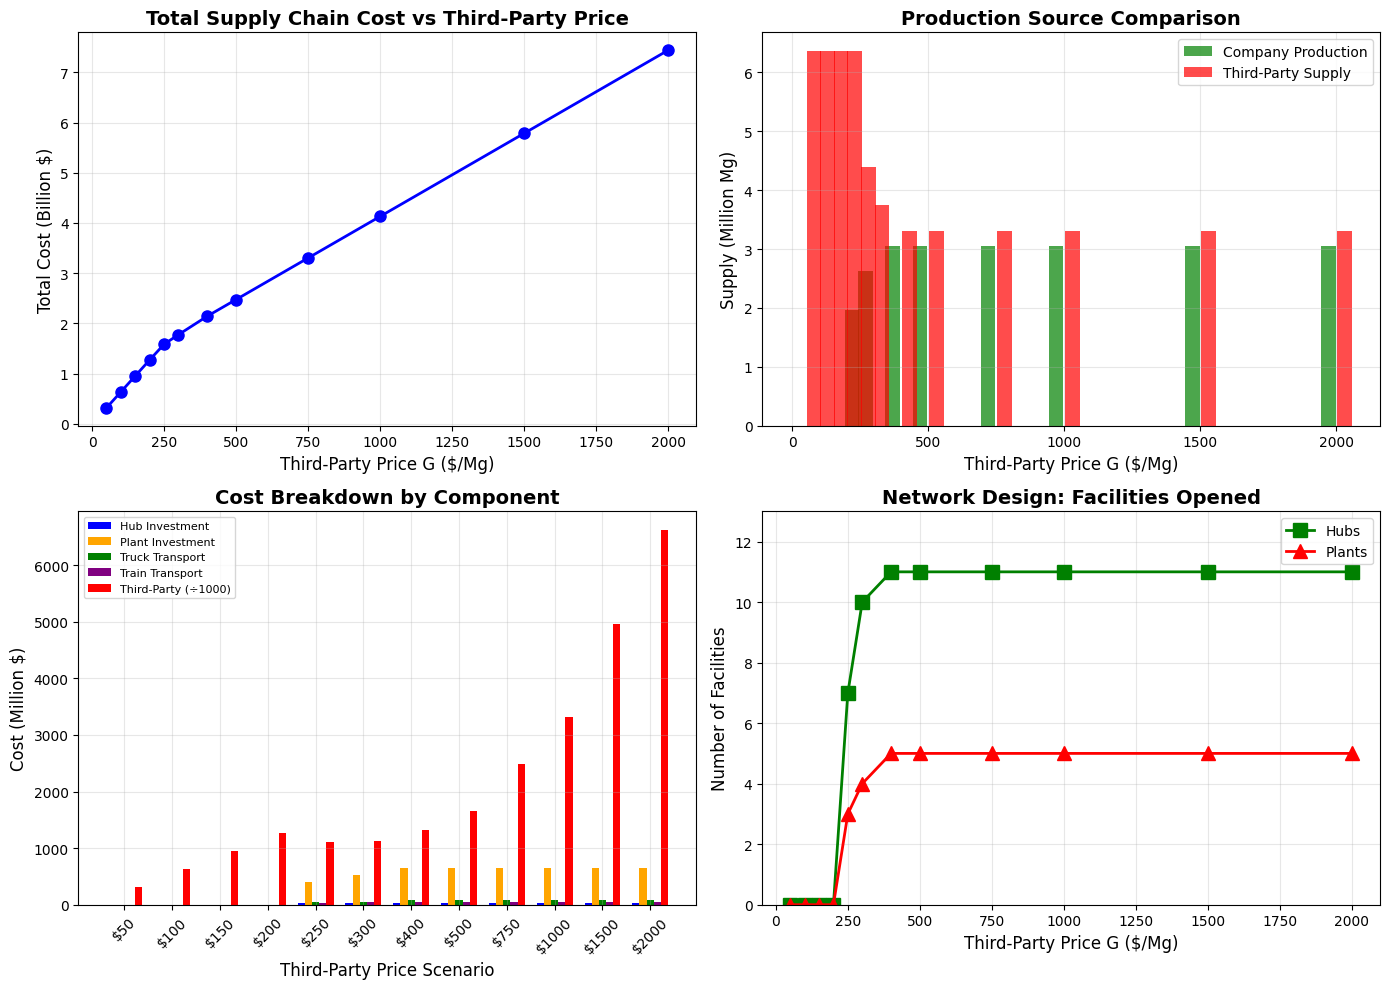


Figure saved as 'sensitivity_analysis.png'


In [ ]:
# -------------------------
# Visualizations
# -------------------------
# Pictures are worth a thousand numbers. Let's plot the key relationships.

df_results = pd.DataFrame(sensitivity_results)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: How does total cost change with third-party price?
ax1 = axes[0, 0]
ax1.plot(df_results['G'], df_results['total_cost']/1e9, 'b-o', linewidth=2, markersize=8)
ax1.set_xlabel('Third-Party Price ($/Mg)')
ax1.set_ylabel('Total Cost (Billion $)')
ax1.set_title('Total Cost vs Third-Party Price')
ax1.grid(True, alpha=0.3)

# Top-right: Where does the biomass come from at each price point?
ax2 = axes[0, 1]
width = 30
ax2.bar(df_results['G'] - width, df_results['company_production']/1e6, 
        width=width*1.8, label='Own Production', color='green', alpha=0.7)
ax2.bar(df_results['G'] + width, df_results['third_party_supply']/1e6, 
        width=width*1.8, label='Third-Party', color='red', alpha=0.7)
ax2.set_xlabel('Third-Party Price ($/Mg)')
ax2.set_ylabel('Supply Volume (Million Mg)')
ax2.set_title('Supply Mix: Own vs Purchased')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom-left: Where does the money go?
ax3 = axes[1, 0]
x = np.arange(len(df_results))
width = 0.15
ax3.bar(x - 2*width, df_results['hub_investment']/1e6, width, label='Hub Investment', color='blue')
ax3.bar(x - width, df_results['plant_investment']/1e6, width, label='Plant Investment', color='orange')
ax3.bar(x, df_results['truck_cost']/1e6, width, label='Trucking', color='green')
ax3.bar(x + width, df_results['train_cost']/1e6, width, label='Rail', color='purple')
ax3.bar(x + 2*width, df_results['third_party_cost']/1e9 * 1000, width, label='3rd Party (÷1000)', color='red')
ax3.set_xlabel('Price Scenario')
ax3.set_ylabel('Cost (Million $)')
ax3.set_title('Cost Breakdown')
ax3.set_xticks(x)
ax3.set_xticklabels([f'${g}' for g in df_results['G']], rotation=45)
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# Bottom-right: How many facilities do we need?
ax4 = axes[1, 1]
ax4.plot(df_results['G'], df_results['num_hubs'], 'g-s', linewidth=2, markersize=10, label='Hubs')
ax4.plot(df_results['G'], df_results['num_plants'], 'r-^', linewidth=2, markersize=10, label='Plants')
ax4.set_xlabel('Third-Party Price ($/Mg)')
ax4.set_ylabel('Number of Facilities')
ax4.set_title('Network Size')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, max(df_results['num_hubs'].max(), df_results['num_plants'].max()) + 2)

plt.tight_layout()
plt.savefig('sensitivity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Charts saved to 'sensitivity_analysis.png'")

In [ ]:
# -------------------------
# Interactive Map
# -------------------------
# Let's see where the facilities actually go. We'll create a map showing
# the hubs and plants selected in the G=$500/Mg solution.

G_map = 500
result_map = next((r for r in sensitivity_results if r['G'] == G_map), None)

if result_map and result_map['status'] == 'optimal':
    opened_hubs_solution = result_map['opened_hubs']
    opened_plants_solution = result_map['opened_plants']
    
    # Get coordinates for the selected facilities
    hub_locations = df2[df2['hub'].isin(opened_hubs_solution)][['hub', 'latitude', 'longitude']].copy()
    plant_locations = df3[df3['plant'].isin(opened_plants_solution)][['plant', 'latitude', 'longitude']].copy()
    
    # Also get all potential locations (to show what we didn't pick)
    all_hub_locations = df2[['hub', 'latitude', 'longitude']].copy()
    all_plant_locations = df3[['plant', 'latitude', 'longitude']].copy()
    
    # Center the map on Texas
    center_lat = (df2['latitude'].mean() + df3['latitude'].mean()) / 2
    center_lon = (df2['longitude'].mean() + df3['longitude'].mean()) / 2
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles='OpenStreetMap')
    
    # Show potential (not selected) hubs as small gray dots
    for _, row in all_hub_locations.iterrows():
        if row['hub'] not in opened_hubs_solution:
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=f"Potential Hub {int(row['hub'])}",
                color='gray',
                fill=True,
                fillColor='gray',
                fillOpacity=0.3
            ).add_to(m)
    
    # Show potential (not selected) plants as light gray dots
    for _, row in all_plant_locations.iterrows():
        if row['plant'] not in opened_plants_solution:
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=f"Potential Plant {int(row['plant'])}",
                color='lightgray',
                fill=True,
                fillColor='lightgray',
                fillOpacity=0.3
            ).add_to(m)
    
    # Highlight the selected hubs (blue)
    for _, row in hub_locations.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"<b>Hub {int(row['hub'])}</b><br>Selected in optimal solution",
            icon=folium.Icon(color='blue', icon='home', prefix='fa'),
            tooltip=f"Hub {int(row['hub'])}"
        ).add_to(m)
    
    # Highlight the selected plants (red)
    for _, row in plant_locations.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"<b>Plant {int(row['plant'])}</b><br>Selected in optimal solution",
            icon=folium.Icon(color='red', icon='industry', prefix='fa'),
            tooltip=f"Plant {int(row['plant'])}"
        ).add_to(m)
    
    # Add a legend
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 160px; 
                border:2px solid grey; z-index:9999; font-size:13px;
                background-color:white; padding: 10px;
                border-radius: 5px;">
    <b>Supply Chain Network</b><br>
    <b>(G = ${G_map}/Mg)</b><br><br>
    <i class="fa fa-home" style="color:blue"></i> Hub ({len(opened_hubs_solution)} selected)<br>
    <i class="fa fa-industry" style="color:red"></i> Plant ({len(opened_plants_solution)} selected)<br>
    <span style="color:gray">●</span> Not selected<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Print summary
    print(f"Supply Chain Map (G = ${G_map}/Mg)")
    print("=" * 60)
    print(f"Selected {len(opened_hubs_solution)} hubs: {[int(h) for h in opened_hubs_solution]}")
    print(f"Selected {len(opened_plants_solution)} plants: {[int(p) for p in opened_plants_solution]}")
    print(f"\nOwn production: {result_map['company_production']/1e6:.2f}M Mg ({result_map['company_production']/D*100:.1f}%)")
    print(f"Third-party: {result_map['third_party_supply']/1e6:.2f}M Mg ({result_map['third_party_supply']/D*100:.1f}%)")
    
    m.save('supply_chain_map.html')
    print(f"\nMap saved to 'supply_chain_map.html'")
    print("Blue = hubs, Red = plants, Gray = not selected")
    
    m
else:
    print("No solution available for mapping.")

SUPPLY CHAIN NETWORK MAP (G = $500/Mg)
Opened Hubs: 11 - [17372, 17466, 17592, 17620, 17679, 17792, 17822, 17829, 17934, 17945, 18127]
Opened Plants: 5 - [541, 543, 9047, 9203, 10066]

Company Production: 3.05 Million Mg (48.0%)
Third-Party Supply: 3.31 Million Mg (52.0%)

Map Legend:
  🔵 Blue markers: Opened Hubs
  🔴 Red markers: Opened Plants
  ⚫ Gray markers: Potential (not selected) locations

Saving map to 'supply_chain_map.html'...
Map saved successfully!


In [ ]:
# -------------------------
# What If We Can't Use Third-Party Supply?
# -------------------------
# Maybe the external market isn't reliable, or company policy forbids it.
# Can we meet demand using only local sources?

def solve_model_no_third_party(D, fj, gk, qj, pk, tj, ljk,
                                suppliers_list, hubs_list, plants_list, 
                                supplier_dict, cost_in_truck, cost_in_train):
    """
    Same optimization, but without the option to buy from third parties.
    All demand must be met from local supplier network.
    """
    model = LpProblem("Bioethanol_No_ThirdParty", LpMinimize)
    
    # Same variables, minus the third-party one
    yj = {j: LpVariable(f"y_{int(j)}", cat='Binary') for j in hubs_list}
    zk = {k: LpVariable(f"z_{int(k)}", cat='Binary') for k in plants_list}
    
    Sij = {(i,j): LpVariable(f"Sij_{int(i)}_{int(j)}", lowBound=0) 
           for i in suppliers_list for j in hubs_list if (i,j) in cost_in_truck}
    Sjk = {(j,k): LpVariable(f"Sjk_{int(j)}_{int(k)}", lowBound=0) 
           for j in hubs_list for k in plants_list if (j,k) in cost_in_train}
    
    # Objective: no third-party term this time
    model += (
        lpSum(fj * yj[j] for j in hubs_list) +
        lpSum(gk * zk[k] for k in plants_list) +
        lpSum(cost_in_truck[i,j] * Sij[i,j] for (i,j) in Sij.keys()) +
        lpSum((cost_in_train[j,k] + ljk) * Sjk[j,k] for (j,k) in Sjk.keys())
    ), "Total_Cost"
    
    # Same constraints as before
    for i in suppliers_list:
        model += lpSum(Sij[i,j] for j in hubs_list if (i,j) in cost_in_truck) <= supplier_dict[i]
    
    for j in hubs_list:
        model += lpSum(Sij[i,j] for i in suppliers_list if (i,j) in cost_in_truck) <= qj * yj[j]
    
    for k in plants_list:
        model += lpSum(Sjk[j,k] for j in hubs_list if (j,k) in cost_in_train) <= pk * zk[k]
    
    for j in hubs_list:
        model += (lpSum(Sij[i,j] for i in suppliers_list if (i,j) in cost_in_truck) >= 
                  lpSum(Sjk[j,k] for k in plants_list if (j,k) in cost_in_train))
    
    for (j,k) in Sjk.keys():
        model += Sjk[j,k] <= tj
    
    # Demand must come entirely from our own network
    model += lpSum(Sjk[j,k] for (j,k) in Sjk.keys()) >= D
    
    model.solve(PULP_CBC_CMD(msg=0, timeLimit=300))
    
    return model, yj, zk, Sij, Sjk

# Let's check if it's even possible
print("Analysis: No Third-Party Supply Option")
print("=" * 70)

total_local_supply = sum(supplier_dict.values())
print(f"\nDemand:       {D:,} Mg")
print(f"Local supply: {total_local_supply:,} Mg")
print(f"Shortfall:    {D - total_local_supply:,} Mg")

if total_local_supply >= D:
    print(f"\nGood news - local supply exceeds demand. Let's optimize...")
    model_no_tp, yj, zk, Sij, Sjk = solve_model_no_third_party(
        D, fj, gk, qj, pk, tj, ljk,
        suppliers_list, hubs_list, plants_list, 
        supplier_dict, cost_in_truck, cost_in_train
    )
    
    if LpStatus[model_no_tp.status] == 'Optimal':
        total_cost_no_tp = pulp.value(model_no_tp.objective)
        company_prod = sum(pulp.value(Sjk[j,k]) for (j,k) in Sjk.keys())
        num_hubs = sum(1 for j in hubs_list if pulp.value(yj[j]) > 0.5)
        num_plants = sum(1 for k in plants_list if pulp.value(zk[k]) > 0.5)
        
        print(f"\nSolution found!")
        print(f"  Total Cost:   ${total_cost_no_tp:,.0f}")
        print(f"  Production:   {company_prod:,.0f} Mg")
        print(f"  Facilities:   {num_hubs} hubs, {num_plants} plants")
    else:
        print(f"\nNo feasible solution - infrastructure can't handle the flow even with enough supply.")
else:
    print(f"\nProblem: Local supply falls short by {D - total_local_supply:,} Mg.")
    print("Third-party purchases are unavoidable.")
    
    # What's the best we can do with local supply only?
    print(f"\nLet's find the maximum we CAN produce locally...")
    
    max_feasible_D = int(total_local_supply * 0.95)  # aim for 95% utilization
    model_max, yj, zk, Sij, Sjk = solve_model_no_third_party(
        max_feasible_D, fj, gk, qj, pk, tj, ljk,
        suppliers_list, hubs_list, plants_list, 
        supplier_dict, cost_in_truck, cost_in_train
    )
    
    if LpStatus[model_max.status] == 'Optimal':
        company_prod = sum(pulp.value(Sjk[j,k]) for (j,k) in Sjk.keys())
        num_hubs = sum(1 for j in hubs_list if pulp.value(yj[j]) > 0.5)
        num_plants = sum(1 for k in plants_list if pulp.value(zk[k]) > 0.5)
        
        print(f"\nMaximum Local Production:")
        print(f"  Can produce:  {company_prod:,.0f} Mg")
        print(f"  That's only:  {company_prod/D*100:.1f}% of demand")
        print(f"  Would need:   {num_hubs} hubs, {num_plants} plants")
        print(f"  Total cost:   ${pulp.value(model_max.objective):,.0f}")
        
        # Compare with third-party scenario
        if sensitivity_results:
            result_with_tp = sensitivity_results[-1]
            print(f"\nComparison (local-only vs with third-party at G=${result_with_tp['G']}/Mg):")
            print(f"  {'':30} Local Only    With Third-Party")
            print(f"  {'Demand satisfied:':<30} {company_prod:>10,.0f}   {D:>10,}")
            print(f"  {'Coverage:':<30} {company_prod/D*100:>9.1f}%   {'100.0':>10}%")
            print(f"  {'Hubs:':<30} {num_hubs:>10}   {result_with_tp['num_hubs']:>10}")
            print(f"  {'Plants:':<30} {num_plants:>10}   {result_with_tp['num_plants']:>10}")

print("\n" + "=" * 70)
print("Bottom Line:")
if total_local_supply < D:
    print(f"  - We MUST use third-party supply. Local sources cover only {total_local_supply/D*100:.1f}%.")
    print(f"  - At minimum, {(D-total_local_supply)/D*100:.1f}% has to come from external sources.")
print("=" * 70)

ANALYSIS: WHAT IF NO THIRD-PARTY SUPPLY IS AVAILABLE?

📊 SUPPLY CAPACITY ANALYSIS:
   Total Demand Required:       6,363,408 Mg
   Total Local Supply Available: 3,053,378 Mg
   Supply Gap:                   3,310,030 Mg

❌ LOCAL SUPPLY INSUFFICIENT!
   Cannot meet 6,363,408 Mg demand with only 3,053,378 Mg local supply.
   Third-party supply of at least 3,310,030 Mg is REQUIRED.

📊 Finding maximum demand that can be met without third-party...

📊 MAXIMUM FEASIBLE PRODUCTION (No Third-Party):
   Maximum Demand Satisfiable: 2,900,708 Mg
   Actual Production:          2,900,708 Mg
   Demand Coverage:            45.6%
   Total Cost:                 $802,804,741.82
   Number of Hubs:             10
   Number of Plants:           5

COMPARISON: With vs Without Third-Party Supply

                           | No Third-Party | With Third-Party (G=$2000/Mg)
   ------------------------|-----------------|--------------------------
   Demand Met              | 2,900,708 Mg   | 6,363,408 Mg
   Deman